# Problem Set 2

This is the second homework assignment, which accounts for $15\%$ of your final grade. There are three questions, and their weights are:
* Q1: $20\%$,
* Q2: $40\%$,
* Q3: $40\%$.

You may work with other students. The maximum number of students per group is two. However, you can work on your own. Be sure to indicate with whom you have worked in your submission.

### Deadline: Nov 6, 2023 (5 PM HK Time). 

There is a penalty for late submissions: $5\%$ will be subtracted from the total mark for every additional day after the deadline. 

---

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
plt.rc('figure', figsize=(8, 4))

---

## Q1. Simple Random Walks Redux

In lecture 4, we introduce the simple random walk process, which starts at zero and increases/decreases by 1 unit with equal probabilities per period. We further introduce a function ```random_walk_simulations_numpy``` that can be used to efficiently simulate multiple random walks using NumPy functionality, as follows:
```python
def random_walk_simulations_numpy(nsteps, nwalks):
    """
    nsteps (int): the number of steps in each random walk process;
    nwalks (int): the number of random walks at once;
    Return two quantities:
    1. walks_max: ndarray with shape (nwalks,) that records the max value across nwalks random walk paths;
    2. walks_min: ndarray with shape (nwalks,) that records the min value across nwalks random walk paths.
    """
    draws = np.random.randint(0, 2, size=(nwalks, nsteps))
    steps = np.where(draws > 0, 1, -1)
    walks = steps.cumsum(1)
    walks_max = walks.max(axis=1)
    walks_min = walks.min(axis=1)
    return walks_max, walks_min
```



Now the question is, can you rewrite the above function ```random_walk_simulations_numpy``` using a nested ```for``` loop? The function specification is given as follows:
```python
def random_walk_simulations_loops(nsteps, nwalks):
    """
    nsteps (int): the number of steps in each random walk process;
    nwalks (int): the number of random walks at once;
    Return two quantities:
    1. walks_max: a list with the length nwalks, which records the max value across nwalks random walk paths;
    2. walks_min: a list with the length nwalks, which records the min value across nwalks random walk paths.

    Note that in this function, you are not allowed to use the numpy package. 
    """
    pass
```
After you create the ```random_walk_simulations_loops``` function, try to run the following codes to compare the run times of ```random_walk_simulations_loops``` and ```random_walk_simulations_numpy```: 
```python
%timeit random_walk_simulations_loops(nsteps=1000, nwalks=1000)
%timeit random_walk_simulations_numpy(nsteps=1000, nwalks=1000)
```

### Answer:

In [2]:
def random_walk_simulations_loops(nsteps, nwalks):
    """
    nsteps (int): the number of steps in each random walk process;
    nwalks (int): the number of random walks at once;
    Return two quantities:
    1. walks_max: a list with the length nwalks, which records the max value across nwalks random walk paths;
    2. walks_min: a list with the length nwalks, which records the min value across nwalks random walk paths.
    
    Note that in this function, you are not allowed to use the numpy package. 
    """

    walks_max = []
    walks_min = []
    for j in range(nwalks):
        position = 0
        walk = [position]
        for i in range(nsteps):
            step = 1 if random.randint(0, 1) else -1    # the sequence either goes up by 1 or declines by 1, with equal probs
            position += step
            walk.append(position)
        walks_max.append(max(walk))
        walks_min.append(min(walk))

    return walks_max, walks_min
    

In [3]:
def random_walk_simulations_numpy(nsteps, nwalks):
    """
    nsteps (int): the number of steps in each random walk process;
    nwalks (int): the number of random walks at once;
    Return two quantities:
    1. walks_max: ndarray with shape (nwalks,) that records the max value across nwalks random walk paths;
    2. walks_min: ndarray with shape (nwalks,) that records the min value across nwalks random walk paths.
    """
    draws = np.random.randint(0, 2, size=(nwalks, nsteps)) # 0 or 1
    steps = np.where(draws > 0, 1, -1)
    walks = steps.cumsum(1)
    walks_max = walks.max(axis=1)
    walks_min = walks.min(axis=1)

    return walks_max, walks_min
    

In [4]:
walks_max, walks_min = random_walk_simulations_loops(nsteps=1000, nwalks=10000)
print(np.quantile(walks_max, (0.05, 0.5, 0.95)))
print(np.quantile(walks_min, (0.05, 0.5, 0.95)))

[ 1. 21. 61.]
[-61. -21.  -2.]


In [5]:
walks_max, walks_min = random_walk_simulations_numpy(nsteps=1000, nwalks=10000)
print(np.quantile(walks_max, (0.05, 0.5, 0.95)))
print(np.quantile(walks_min, (0.05, 0.5, 0.95)))

[ 2. 21. 62.]
[-63. -21.  -1.]


In [6]:
%timeit random_walk_simulations_loops(nsteps=1000, nwalks=1000)

%timeit random_walk_simulations_numpy(nsteps=1000, nwalks=1000)

747 ms ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.1 ms ± 757 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

## Q2. Modelling Stock Prices via Generalized Random Walks

In Q1, we consider the simple random walk, which starts at 0 and moves with steps of 1 and -1 occuring with equal probability. Suppose we use $X_t$ to denote such a simple random walk, $\Delta t$ is the time step (e.g., one trading day or week, etc.), and $\Delta X_{t+\Delta t} = X_{t+\Delta t} - X_{t}$ denotes the movement between time $t$ and $t+\Delta t$. The definition of simple random walks implies that 
$$
\mathbf{P} [\Delta X_{t+\Delta t} = 1] = \mathbf{P} [\Delta X_{t+\Delta t} = -1] = \frac{1}{2}. 
$$
In other words, $X_t$ increases or decreases by 1 unit with equal probabilities. 

In this question, we twist the simple walk to model stock returns/prices. Suppose that we are interested in the S&P 500 index. The behaviors of this stock index are similar to the simple random walk in the sense that it is difficult to predict. However, the stock index tends to increase in the long run. For example, the average annualized return of the S&P 500 index is around $10\%$. We also want to change the step size of the simple random walk to fit the real behavior of the stock return. Let's use $P_t$ to denote the S&P 500 index (the stock price), so its return between time $t$ and $t+\Delta t$ is defined as 
$$
R_{t+\Delta t} = \frac{P_{t+\Delta t} - P_t}{P_t},
$$
and we model the behavior of $R_{t+\Delta t}$ as follows: 
$$
R_{t+\Delta t} = \mu \times \Delta t + \sigma \times \sqrt{\Delta t} \times \Delta X_{t+\Delta t},
$$
where $\mu$ and $\sigma$ are the mean and standard deviation of the underlying asset, and $X_{t+\Delta t}$ follows the simple random walk process such that $\mathbf{P} [\Delta X_{t+\Delta t} = 1] = \mathbf{P} [\Delta X_{t+\Delta t} = -1] = \frac{1}{2}$. Finally, the cumulative stock return between time $t$ and $T$, denoted as $R_{t \to T}$, is approximated as follows:
$$
R_{t \to T} = \prod^{\frac{T-t}{\Delta t}}_{i=1} \big(1 + R_{t+ i \cdot \Delta t} \big) - 1,
$$
which implies $P_T = P_t \cdot (1 + R_{t \to T})$. Here, we assume that $\frac{T-t}{\Delta t}$ is an integer (we can also guarantee this condition by choosing a suitable $\Delta t$).

### Q2.1

In this question, you are asked to write a ```stock_price_simulations``` function to simulate stock prices based on the above description. In particular, you need to follow the function specification as follows:
```python
def stock_price_simulations(P0, delta_t, mu, sigma, nsteps, nwalks):
    """
    P0: the current stock price;
    delta_t: the time step, double numeric;
    mu, sigma: mean and standard deviation of the stock return, double numeric;
    nsteps: the number of steps in each stock return random walk, integer;
    nwalks: the number of stock return random walks, integer;
    Return: a two-dimensional np.array, with each row storing one draw of stock price
            random walk with nsteps. 
    """
```
After you finish the above function, you need to create a two-dimensional array by running the following codes:
```python
P1_sim = stock_price_simulations(P0, delta_t, mu, sigma, nsteps, nwalks)
```
with the values of parameters given below:
```python
np.random.seed(12345)  
mu = 0.10      # mean stock return
sigma = 0.20   # annualised standard deviation
delta_t = 1/252   # a trading day
nsteps = int(1 / delta_t)  # one-year holding horizon
nwalks = 10000   # the number of random walk simulations
P0 = 50.0
```
Finally, you need to use the ```matplotlib.pyplot``` module to plot the distribution of the stock price in the final period (using the histogram). 

### Answer:

In [7]:
np.random.seed(12345)  
mu = 0.10      # mean stock return
sigma = 0.15   # annualised standard deviation
delta_t = 1/252   # a trading day
nsteps = int(1 / delta_t)  # one-year holding horizon
nwalks = 10000   # the number of random walk simulations
P0 = 50.0

In [8]:
def stock_price_simulations(P0, delta_t, mu, sigma, nsteps, nwalks):
    """
    P0: the current stock price;
    delta_t: the time step, double numeric;
    mu, sigma: mean and standard deviation of the stock return, double numeric;
    nsteps: the number of steps in each stock return random walk, integer;
    nwalks: the number of stock return random walks, integer;
    Return: a two-dimensional np.array, with each row storing one draw of stock price
            random walk with nsteps. 
    """
    
    draws = np.random.randint(0, 2, size=(nwalks, nsteps))
    steps = np.where(draws > 0, 1, -1)
    returns = steps*sigma*np.sqrt(delta_t) + mu*delta_t
    P1 = P0 * (1+returns).cumprod(axis=1)
    return P1


In [9]:
np.random.seed(12345)
P1_sim = stock_price_simulations(P0, delta_t, mu, sigma, nsteps, nwalks)
print(P1_sim.shape)

(10000, 252)


(array([3.100e+01, 9.600e+01, 4.470e+02, 8.800e+02, 1.001e+03, 1.817e+03,
        1.504e+03, 1.404e+03, 1.090e+03, 8.170e+02, 3.440e+02, 3.110e+02,
        1.270e+02, 8.500e+01, 2.300e+01, 1.400e+01, 4.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 32.80880041,  36.16892371,  39.52904701,  42.8891703 ,
         46.2492936 ,  49.6094169 ,  52.9695402 ,  56.3296635 ,
         59.6897868 ,  63.0499101 ,  66.4100334 ,  69.7701567 ,
         73.13028   ,  76.4904033 ,  79.8505266 ,  83.2106499 ,
         86.5707732 ,  89.9308965 ,  93.2910198 ,  96.6511431 ,
        100.0112664 ]),
 <BarContainer object of 20 artists>)

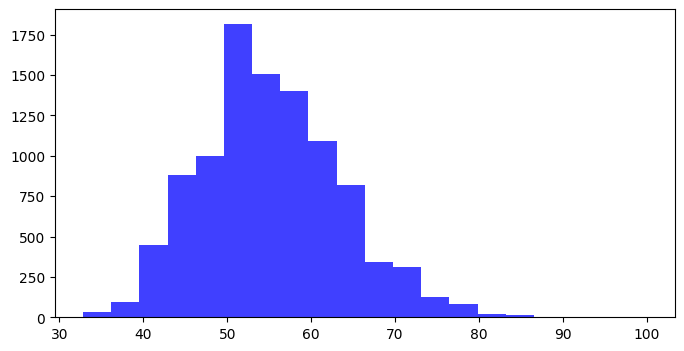

In [10]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
axes.hist(P1_sim[:,-1], bins=20, color='b', alpha=0.75)

### Q2.2

Based on the simulated stock prices in Q2.1, what is the probability of the terminal stock price being greater than $60? (Hint: You need to count the percentages of the stock prices in the final trading period being larger than 60).

Second, how does the probability of the terminal stock price being greater than $60 depend on the values of ```mu``` and ```sigma```? To answer this question, you need to consider a variety of ```mu``` and ```sigma```, as follows:
```python
mu_seq = np.arange(0.05, 0.3, 0.01)
sigma_seq = np.arange(0.05, 0.3, 0.01)
```

For each pair of ```mu``` and ```sigma``` in ```mu_seq``` and ```sigma_seq```, you need to estimate the probability of the terminal stock prices being greater than $60. Based on your estimates, please briefly describe how the values of ```mu``` and ```sigma``` determine the probability that the stock price is larger than \$60 in the final trading period. 

In [11]:
print('The probability of the terminal stock pricing being greater than $60 is', (P1_sim[:,-1] > 60).mean())

The probability of the terminal stock pricing being greater than $60 is 0.282


In [12]:
mu_seq = np.arange(0.05, 0.3, 0.01)
sigma_seq = np.arange(0.05, 0.3, 0.01)
probs = np.zeros((len(mu_seq), len(sigma_seq)))

for i in range(len(mu_seq)):
    print('i =', i)
    mu_i = mu_seq[i]
    for j in range(len(sigma_seq)):
        #print('j =', j)
        sigma_j = sigma_seq[j]
        P1_sim_ij = stock_price_simulations(P0, delta_t, mu_i, sigma_j, nsteps, nwalks)
        probs[i,j] = (P1_sim_ij[:,-1] > 60).mean()
        

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24


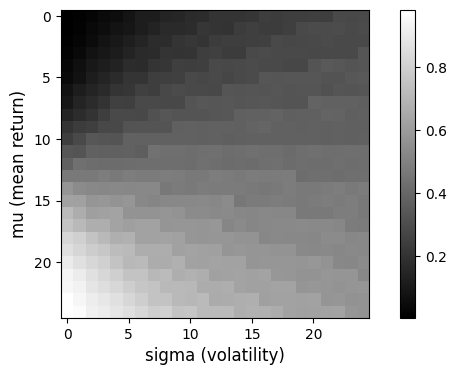

In [13]:
plt.imshow(probs, cmap=plt.cm.gray)
plt.colorbar()

plt.xlabel('sigma (volatility)', fontsize=12)
plt.ylabel('mu (mean return)', fontsize=12)

plt.show()

In [14]:
probs_df = pd.DataFrame(probs, index=mu_seq, columns=sigma_seq)

probs_df

,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,...,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29
0.05,0.0039,0.0140,0.0268,0.0438,0.0571,0.0825,0.1168,0.1170,0.1455,0.1496,...,0.2103,0.2434,0.2404,0.2420,0.2421,0.2466,0.2422,0.2866,0.2808,0.2851
0.06,0.0070,0.0174,0.0396,0.0544,0.0780,0.0913,0.1174,0.1389,0.1662,0.1675,...,0.2477,0.2401,0.2357,0.2450,0.2834,0.2903,0.2928,0.2948,0.2895,0.2925
0.07,0.0099,0.0248,0.0476,0.0769,0.0974,0.1201,0.1423,0.1736,0.1742,0.2078,...,0.2458,0.2519,0.2849,0.2771,0.2802,0.2832,0.2902,0.2839,0.2853,0.2856
0.08,0.0187,0.0410,0.0735,0.0937,0.1142,0.1393,0.1665,0.1687,0.2096,0.2012,...,0.2866,0.2920,0.2828,0.2876,0.2841,0.2820,0.2880,0.2853,0.2864,0.3321
0.09,0.0332,0.0612,0.0972,0.1165,0.1338,0.1736,0.1700,0.2059,0.2109,0.2473,...,0.2927,0.2887,0.2868,0.2770,0.2774,0.3248,0.3444,0.3366,0.3277,0.3359
0.10,0.0442,0.0734,0.1165,0.1453,0.1692,0.2054,0.2077,0.2412,0.2453,0.2492,...,0.2905,0.3337,0.3287,0.3353,0.3333,0.3328,0.3244,0.3225,0.3364,0.3447
0.11,0.0727,0.1178,0.1455,0.1666,0.2054,0.2106,0.2482,0.2407,0.2824,0.2921,...,0.3309,0.3273,0.3344,0.3281,0.3321,0.3303,0.3194,0.3288,0.3277,0.3347
0.12,0.0953,0.1445,0.1694,0.2020,0.2514,0.2453,0.2869,0.2871,0.2818,0.2824,...,0.3358,0.3374,0.3310,0.3251,0.3273,0.3839,0.3749,0.3773,0.3816,0.3690
0.13,0.1441,0.1725,0.2014,0.2407,0.2885,0.2891,0.2821,0.3188,0.3344,0.3266,...,0.3766,0.3776,0.3849,0.3686,0.3719,0.3726,0.3874,0.3846,0.3700,0.3729
0.14,0.2085,0.2388,0.2478,0.2806,0.2804,0.3225,0.3274,0.3252,0.3252,0.3712,...,0.3852,0.3898,0.3765,0.3815,0.3728,0.3756,0.3714,0.3753,0.3712,0.3738


#### Conclusion

* The probability of stock prices being larger than $\$60$ is strictly increasing in the mean return parameter $\mu$. This observation is intuitive because higher mean returns imply that future stock prices, on average, tend to be higher. <br>
<br>
* However, the relationship between the probability and the volatility parameter $\sigma$ is mixed. When the mean return parameter $\mu$ is small (e.g., $\mu <= 0.15$), The probability of stock prices being larger than $\$60$ is strictly increasing in the volatility parameter $\sigma$. However, in the cases of high $\mu$, the probability is smaller for a larger volatility parameter $\sigma$. 

---

## Q3. Using SQL ```SELECT``` Statement

In this question, you will need to create a ```.db``` file and use the **SQL** (more precisely, ```SQLite3```) statements to explore the database. 

### Q3.1

First, you need to create a database named ```"ps2_stocks.db"```, with three tables in this dataset. 
* 'stock_returns': contains four variables, ```['key', 'id', 'eom', 'ret_exc_lead1m']```;
* 'st_reversal_signals': contains nine variables ```['key', 'id', 'eom', 'iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 'ret_1_0', 'rmax5_rvol_21d', 'rskew_21d']```;
* 'quality_signal': contains eight variables ```['key', 'id', 'eom', 'at_turnover', 'cop_at', 'cop_atl1', 'dgp_dsale', 'gp_at']```, 

where the variable ```'key'``` is the primary key of the dataset. **You need to create your own primary key**. <br>

Note that all the above variables can be found in the ```HK_stocks_151signals.parquet``` file that we used during the lecture.

After you create the ```"ps2_stocks.db"``` database, you will need to get the table information as follows:
```python
Information about table stock_returns:

[(0, 'key', 'INTEGER', 0, None, 0),
 (1, 'id', 'REAL', 0, None, 0),
 (2, 'eom', 'TIMESTAMP', 0, None, 0),
 (3, 'ret_exc_lead1m', 'REAL', 0, None, 0)]

Information about table st_reversal_signals:
[(0, 'key', 'INTEGER', 0, None, 0),
 (1, 'id', 'REAL', 0, None, 0),
 (2, 'eom', 'TIMESTAMP', 0, None, 0),
 (3, 'iskew_capm_21d', 'REAL', 0, None, 0),
 (4, 'iskew_ff3_21d', 'REAL', 0, None, 0),
 (5, 'iskew_hxz4_21d', 'REAL', 0, None, 0),
 (6, 'ret_1_0', 'REAL', 0, None, 0),
 (7, 'rmax5_rvol_21d', 'REAL', 0, None, 0),
 (8, 'rskew_21d', 'REAL', 0, None, 0)]

Information about table quality_signals:
[(0, 'key', 'INTEGER', 0, None, 0),
 (1, 'id', 'REAL', 0, None, 0),
 (2, 'eom', 'TIMESTAMP', 0, None, 0),
 (3, 'at_turnover', 'REAL', 0, None, 0),
 (4, 'cop_at', 'REAL', 0, None, 0),
 (5, 'cop_atl1', 'REAL', 0, None, 0),
 (6, 'dgp_dsale', 'REAL', 0, None, 0),
 (7, 'gp_at', 'REAL', 0, None, 0)]
```

In [15]:
D = pd.read_parquet(r"D:\OneDrive - The University Of Hong Kong\HKU TA\Fall 2024-2025\FINA2390\data_to_share\HK_stocks_151signals.parquet", engine='pyarrow')
D['key'] = D.index

identifier_var_list = ['key', 'id', 'eom', 'ret_exc_lead1m']
st_reversal_list = ['key', 'id', 'eom', 'iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 'ret_1_0', 'rmax5_rvol_21d', 'rskew_21d']
quality_list = ['key', 'id', 'eom', 'at_turnover', 'cop_at', 'cop_atl1', 'dgp_dsale', 'gp_at']


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\OneDrive - The University Of Hong Kong\\HKU TA\\Fall 2024-2025\\FINA2390\\data_to_share\\HK_stocks_151signals.parquet'

In [23]:
conn = sqlite3.connect('ps2_stocks.db')
D[identifier_var_list].to_sql('stock_returns', conn, if_exists='replace', index=False)
D[st_reversal_list].to_sql('st_reversal_signals', conn, if_exists='replace', index=False)
D[quality_list].to_sql('quality_signals', conn, if_exists='replace', index=False)
conn.close()

In [24]:
conn = sqlite3.connect('ps2_stocks.db')
c = conn.cursor()

In [25]:
query = """
PRAGMA table_info('stock_returns')  -- Get the table information
"""

stock_returns = c.execute(query)
print("Information about table stock_returns:")
stock_returns.fetchall()

Information about table stock_returns:


[(0, 'key', 'INTEGER', 0, None, 0),
 (1, 'id', 'REAL', 0, None, 0),
 (2, 'eom', 'TIMESTAMP', 0, None, 0),
 (3, 'ret_exc_lead1m', 'REAL', 0, None, 0)]

In [26]:
query = """
PRAGMA table_info('st_reversal_signals')  -- Get the table information
"""

size_signals = c.execute(query)
print("Information about table st_reversal_signals:")
size_signals.fetchall()

Information about table st_reversal_signals:


[(0, 'key', 'INTEGER', 0, None, 0),
 (1, 'id', 'REAL', 0, None, 0),
 (2, 'eom', 'TIMESTAMP', 0, None, 0),
 (3, 'iskew_capm_21d', 'REAL', 0, None, 0),
 (4, 'iskew_ff3_21d', 'REAL', 0, None, 0),
 (5, 'iskew_hxz4_21d', 'REAL', 0, None, 0),
 (6, 'ret_1_0', 'REAL', 0, None, 0),
 (7, 'rmax5_rvol_21d', 'REAL', 0, None, 0),
 (8, 'rskew_21d', 'REAL', 0, None, 0)]

In [27]:
query = """
PRAGMA table_info('quality_signals')  -- Get the table information
"""

profitability_signals = c.execute(query)
print("Information about table quality_signals:")
profitability_signals.fetchall()

Information about table quality_signals:


[(0, 'key', 'INTEGER', 0, None, 0),
 (1, 'id', 'REAL', 0, None, 0),
 (2, 'eom', 'TIMESTAMP', 0, None, 0),
 (3, 'at_turnover', 'REAL', 0, None, 0),
 (4, 'cop_at', 'REAL', 0, None, 0),
 (5, 'cop_atl1', 'REAL', 0, None, 0),
 (6, 'dgp_dsale', 'REAL', 0, None, 0),
 (7, 'gp_at', 'REAL', 0, None, 0)]

### Q3.2

Select the stock-month observations from the ```'stock_returns'``` table that satisfy the following requirements:
* Select all four variables
* The stock return should be between $-0.05$ and $0.05$ and is NOT missing
* The stock id contains ```999```
* Sort the data by ```eom``` and ```id``` in order
* Select only 10 lines from the sorted data. 

In [28]:
query = """
SELECT *
FROM stock_returns
WHERE (ret_exc_lead1m IS NOT NULL) AND (ret_exc_lead1m BETWEEN -0.05 AND 0.05) AND (id LIKE '%999%') 
ORDER BY eom, id
LIMIT 10;
"""

stock_returns = c.execute(query)
stock_returns.fetchall()

[(13815424, 310199901.0, '1994-03-31 00:00:00', 0.031024886866987695),
 (13815425, 310199901.0, '1994-04-30 00:00:00', -0.02266103688647826),
 (13815428, 310199901.0, '1994-07-31 00:00:00', -0.0436090144638347),
 (13815435, 310199901.0, '1995-02-28 00:00:00', 0.007507454559819797),
 (13815436, 310199901.0, '1995-03-31 00:00:00', -0.016917381368379215),
 (13815438, 310199901.0, '1995-05-31 00:00:00', -0.04369333908221563),
 (13815439, 310199901.0, '1995-06-30 00:00:00', 0.01839917445883646),
 (13815441, 310199901.0, '1995-08-31 00:00:00', 0.040565027005489925),
 (13815443, 310199901.0, '1995-10-31 00:00:00', 0.006818047690114071),
 (13815444, 310199901.0, '1995-11-30 00:00:00', -0.002218889579937491)]

### Q3.3

Compute the average, maximal, and minimal returns for the stocks that satisfy the following requirements: 
* Report ```id``` and create three new variables (```mean_ret```, ```max_ret```, and ```min_ret```) to denote the average, maximal, and minimal returns for selected stocks
* The stock returns should NOT be missing
* The number of time-series observations is greater than 300.

In [29]:
query = """
SELECT id, AVG(ret_exc_lead1m) AS mean_ret,
           MAX(ret_exc_lead1m) AS max_ret,
           MIN(ret_exc_lead1m) AS min_ret
FROM stock_returns
WHERE ret_exc_lead1m IS NOT NULL
GROUP BY id
HAVING COUNT(*) >= 300;
"""

stock_returns = c.execute(query)
stock_returns.fetchall()

[(301549801.0, 0.011849556251250023, 0.3644695480263899, -0.34172146736385356),
 (301553001.0, 0.008723591970903406, 0.429555675584667, -0.40459684028281695),
 (301565201.0, 0.012885477092200089, 0.6838678906050226, -0.5035261315692069),
 (301569701.0, 0.012151862260591513, 0.6738806111148733, -0.3595512534335452),
 (301574903.0, 0.009997905664149806, 0.7881577880345717, -0.40755143635464497),
 (301584001.0, 0.013545973311439802, 0.9729439396129388, -0.4563474840012173),
 (301653801.0,
  0.0039021109582900973,
  0.40283942103119386,
  -0.2877994886073407),
 (301659001.0, 0.008450191554195558, 0.2331281874621617, -0.2142364014030549),
 (301659101.0, 0.01024646370488974, 0.5785238469133932, -0.5459306124212623),
 (301662101.0, 0.012944148776402523, 0.592720549160016, -0.44267442626635867),
 (301852602.0, 0.010030831897475062, 0.2691206739063859, -0.23254482737986767),
 (301864901.0, 0.008147282456261302, 0.3571840333237629, -0.27550286077612346),
 (301908301.0, 0.009418919065110101, 0.72

### Q3.4

In this question, you are asked to merge both the ```iskew_capm_21d``` in table ```st_reversal_signals``` and ```at_turnover``` in table ```quality_signals``` into the ```stock_returns``` table.

In [30]:
query = """
SELECT stock_returns.key,  
       stock_returns.id, 
       stock_returns.eom, 
       ret_exc_lead1m, iskew_capm_21d, at_turnover
FROM stock_returns, st_reversal_signals, quality_signals
WHERE st_reversal_signals.key = stock_returns.key AND quality_signals.key = stock_returns.key;
"""

stock_returns = c.execute(query)
stock_returns.fetchall()

[(13581256,
  310108801.0,
  '1990-07-31 00:00:00',
  -0.09400676194570491,
  0.5572678277916787,
  None),
 (13581257,
  310108801.0,
  '1990-08-31 00:00:00',
  -0.14569978347999013,
  -0.012096505627754568,
  None),
 (13581258,
  310108801.0,
  '1990-09-30 00:00:00',
  0.15107615827555618,
  0.4585863894694087,
  None),
 (13581259,
  310108801.0,
  '1990-10-31 00:00:00',
  0.017782245901352873,
  0.23135680596575778,
  None),
 (13581260,
  310108801.0,
  '1990-11-30 00:00:00',
  0.020162740476097583,
  -0.46961215057489897,
  None),
 (13581261,
  310108801.0,
  '1990-12-31 00:00:00',
  0.10634087906704814,
  0.28888891482717677,
  None),
 (13581262,
  310108801.0,
  '1991-01-31 00:00:00',
  0.04320242424320072,
  0.9115974224678193,
  None),
 (13581263,
  310108801.0,
  '1991-02-28 00:00:00',
  0.22126074089995698,
  -0.13700067100698213,
  None),
 (13581264,
  310108801.0,
  '1991-03-31 00:00:00',
  -0.033720972104480905,
  0.8463746069038167,
  None),
 (13581265,
  310108801.0,
  '1

### Q3.5

Compute the average returns per period (grouped by ```eom```) that satisfy the following requirements: 
* Report ```eom``` and create a new variable ```mean_ret``` to denote the average returns for selected observations
* The observations should satisfy ```rmax5_rvol_21d > 0.5``` and ```gp_at > 0.1```
* Sorted by ```eom```.

In [31]:
query = """
SELECT eom, AVG(ret_exc_lead1m) AS mean_ret
FROM stock_returns
WHERE key IN (SELECT key
              FROM st_reversal_signals
              WHERE rmax5_rvol_21d > 0.5 AND key IN (SELECT key
                                                     FROM quality_signals
                                                     WHERE gp_at > 0.1))
GROUP BY eom
ORDER BY eom;
"""

stock_returns = c.execute(query)
stock_returns.fetchall()

[('1990-07-31 00:00:00', -0.0646101327147018),
 ('1990-08-31 00:00:00', -0.11410283078768603),
 ('1990-10-31 00:00:00', -0.030509871472590475),
 ('1990-11-30 00:00:00', 0.06001328475547088),
 ('1990-12-31 00:00:00', 0.049794316030577046),
 ('1991-01-31 00:00:00', 0.05974973614251474),
 ('1991-02-28 00:00:00', -0.02513030790261297),
 ('1991-03-31 00:00:00', -0.061466223531133374),
 ('1991-04-30 00:00:00', 0.030328233849623402),
 ('1991-05-31 00:00:00', -0.003944635753779256),
 ('1991-06-30 00:00:00', 0.049819362151065597),
 ('1991-07-31 00:00:00', -0.01333927117497019),
 ('1991-08-31 00:00:00', 0.012558512928044392),
 ('1991-09-30 00:00:00', 0.016572022617444643),
 ('1991-10-31 00:00:00', 0.013381448437975674),
 ('1991-11-30 00:00:00', 0.0284924292070209),
 ('1991-12-31 00:00:00', -0.020906702444133472),
 ('1992-01-31 00:00:00', 0.02663521094365706),
 ('1992-02-29 00:00:00', 0.008748994022237656),
 ('1992-03-31 00:00:00', 0.12500502379124773),
 ('1992-04-30 00:00:00', 0.0560845442043831

In [32]:
conn.close()

---

# END